In [2]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import pickle
import os
import pandas as pd
from collections import Counter, defaultdict
from visualisation_utils import VisualisationUtils
sns.set_context("talk")
sns.set_style("white")
utils = VisualisationUtils()

### Section 3.2: Control setup

In [2]:
def control_setup():
    probing_results = defaultdict(lambda: dict())
    for modeln, model in utils.model_setups:
        for dataset in utils.control_setup_ds_names:
            accuracy1, accuracy2 = [], []
            for target, fr in utils.control_setups:
                fn_frozen = f"../results/probing/{dataset}/{model}_seed=1_freeze=embeddings-0-1-2-3-4-5-6-7-8-9-10-11_epoch=50.pt.pickle"
                fn = f"../results/probing/{dataset}/{model}_seed=1_freeze={fr}_epoch=50.pt.pickle"
                results_fr = pickle.load(open(fn_frozen, 'rb'))
                results = pickle.load(open(fn, 'rb'))
    
                counts = Counter()
                for l in range(1, 13):
                    over_seeds = []
                    for s in range(5):
                        baseline = results["predict_noise"][s, l - 1]["all"] if l != 1 else \
                            results_fr["predict_noise"][s, l]["all"]
                        over_seeds.append(results["predict_noise"][s, l]["all"] - baseline)
                    counts[l] = max(0, np.mean(over_seeds))

                for l in counts.most_common(1):
                    accuracy1.append(l[0] - 1 in target)
                for l in counts.most_common(2):
                    accuracy2.append(l[0] - 1 in target)

            probing_results[modeln, dataset]["accuracy@1"] = np.mean(accuracy1)
            probing_results[modeln, dataset]["accuracy@2"] = np.mean(accuracy2)

    pickle.dump(dict(probing_results), open("pickled_results/probing_control.pickle", 'wb'))


control_setup()

## Section 4: main results

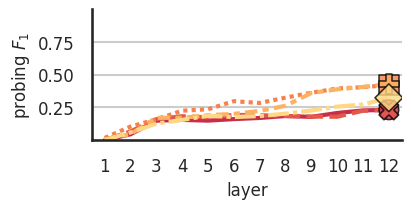

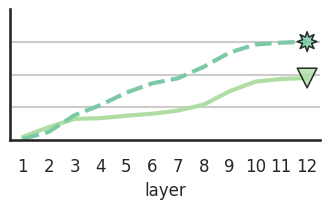

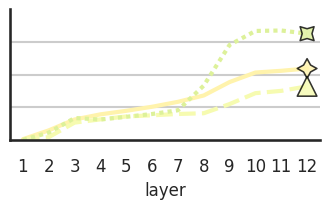

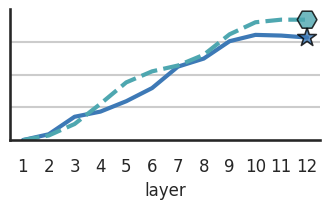

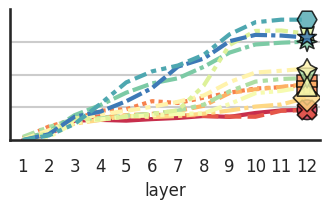

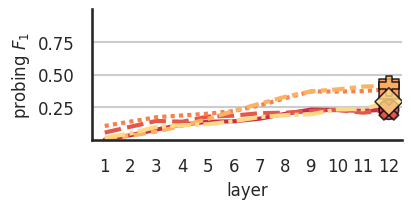

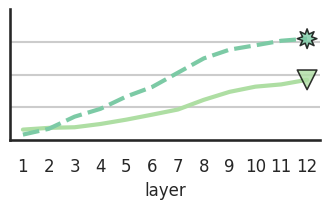

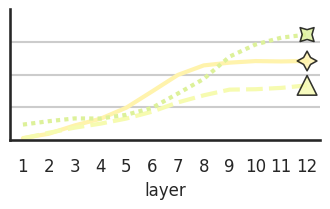

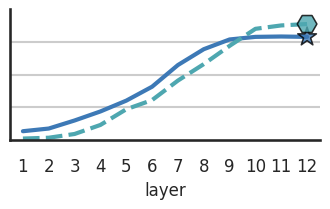

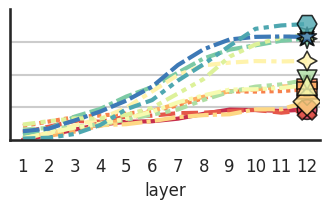

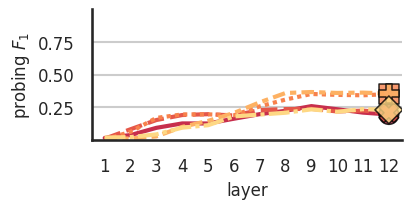

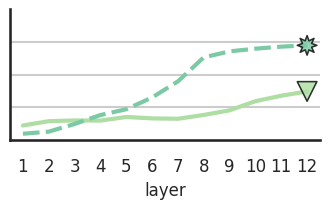

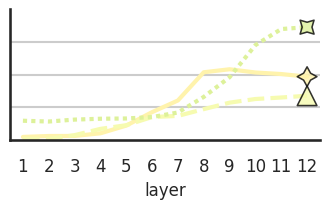

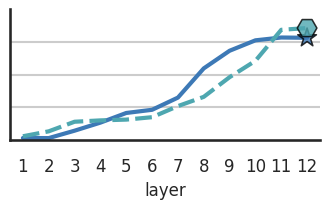

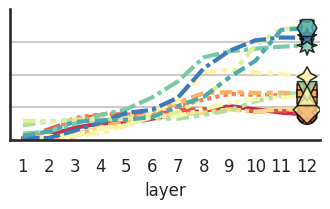

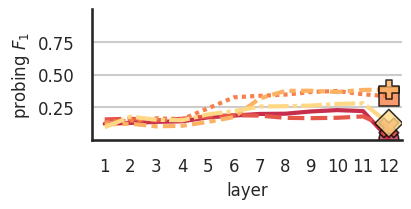

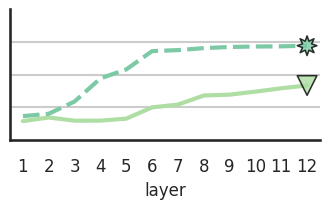

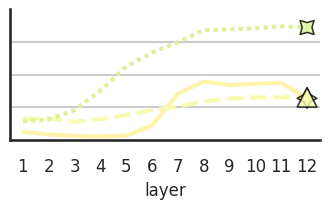

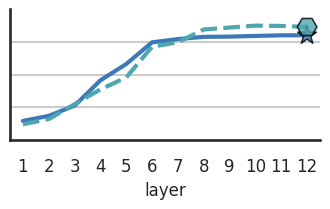

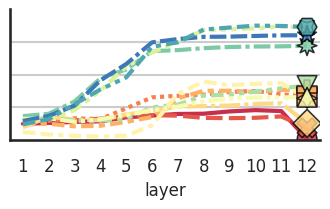

In [3]:
def process_probing(compute_difference, seeds=[1, 2, 3]):
    probing_results = defaultdict(lambda: dict())
    mcog = defaultdict(lambda: dict())
    
    for modeln, model in utils.model_setups:
        for setup, ds_names in utils.data_setups:
            allx, ally, allh = [], [], []
            for dataset in ds_names:
                    over_seeds = []
                    for seed in seeds:
                        prefix = f"../results/probing/{dataset}/{model}_seed="
                        fn = f"{prefix}{seed}_freeze=embeddings_epoch=50.pt.pickle"
                        if dataset == "rte":
                            fn_frozen = f"{prefix}1_freeze=embeddings-0-1-2-3-4-5-6-7-8-9-10-11_epoch=50.pt.pickle"
                        else:
                            fn_frozen = f"{prefix}1_freeze=embeddings-0-1-2-3-4-5-6-7-8-9-10-11-fullfreeze_epoch=50.pt.pickle"
                        
                        over_layers = []
                        results_fr = pickle.load(open(fn_frozen, 'rb'))
                        results = pickle.load(open(fn, 'rb'))
                        for l in range(1, 13):
                            over_probe_seeds = []
                            for s in range(5):
                                if compute_difference:
                                    baseline = results_fr["predict_noise"][s, l]["all"] if l == 1 else \
                                        results["predict_noise"][s, l - 1]["all"]
                                    over_probe_seeds.append(results["predict_noise"][s, l]["all"] - baseline)
                                else:
                                    over_probe_seeds.append(results["predict_noise"][s, l]["all"])
                            over_layers.append(max(0, np.mean(over_probe_seeds)))
                        over_seeds.append(over_layers)    
                    mean_over_seeds = np.mean(over_seeds, axis=0).tolist()
                    mcog[model][dataset] = \
                       (np.sum([x_*y_ for x_, y_ in zip(range(0, 12), over_layers)])/np.sum(mean_over_seeds))
                    probing_results[model][dataset] = mean_over_seeds
                    ally.extend(mean_over_seeds)
                    allx.extend(range(0, 12))
                    allh.extend([dataset]*12)

            if not compute_difference:
                # Visualise the probing f1 per layer
                plt.figure(figsize=(4, 1.7))
                sns.set_style("white")
                plt.grid(axis='y', zorder=-1)
                ax = sns.lineplot(x=allx, y=ally, hue=allh, palette=utils.palette, style=allh, zorder=1,
                                     linewidth=3)
                # Only include scatterplot for last layer to avoid visual clutter
                ax = sns.scatterplot(
                    x=[y for y, z in zip(allx, allx) if z == 11],
                    y=[y for y, z in zip(ally, allx) if z == 11],
                    hue=[y for y, z in zip(allh, allx) if z == 11],
                    palette=utils.palette, style=[y for y, z in zip(allh, allx) if z == 11],
                    markers=utils.marker_dict, edgecolor='black', s=200, alpha=0.8)
                plt.legend(bbox_to_anchor=(1, 1.05))
                plt.legend([],[], frameon=False)
                plt.xlabel("layer", fontsize=12)
                
                plt.xlim(-0.5, 11.5)
                plt.ylim(0, 0.85)
                plt.yticks([0.25, 0.5, 0.75])
                locs, labels = plt.yticks()
                # Only include ylabel for NLU, we'll put the graphs next to each other
                if setup == "nlu":
                    ax.set_yticks(locs, [f"{l:.2f}" for l in locs], fontsize=12)
                    plt.ylabel(f"probing $F_1$", fontsize=12)
                else:
                    ax.set_yticks(locs, [], fontsize=12)
                    plt.ylabel("")
                plt.ylim(0, 1)
                plt.xticks(range(0, 12), range(1, 13), fontsize=12)
                sns.despine(top=True, right=True)
                plt.savefig(f"probing/probing_{setup}_{modeln}.pdf", bbox_inches="tight")
                plt.show()
    return dict(probing_results), dict(mcog)

probing_results, mcog = process_probing(compute_difference=True)
pickle.dump((dict(probing_results), dict(mcog)), open("pickled_results/probing_main.pickle", 'wb'))
_, _ = process_probing(compute_difference=False)

### Section 5: Consolidation via probing

First, visualise the probes' performances for original vs noisy labels (for noisy examples) and for original labels (for clean examples).

In [4]:
import sys
import random
sys.path.append("../src")
from data import preprocess_dataset
import sklearn.metrics

random_performance = defaultdict(lambda: dict())
for dataset in utils.ds_names:
    ds, _ = preprocess_dataset(dataset)
    y_true = [x["labels"] for x in ds["train"]]
    y_pred = [x["labels"] for x in ds["train"]]
    random.shuffle(y_pred)
    random_performance[dataset] = sklearn.metrics.f1_score(y_true, y_pred, average="macro")

/home/vernadankers/anaconda3/envs/memloc/lib/python3.9/site-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")
/home/vernadankers/anaconda3/envs/memloc/lib/python3.9/site-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


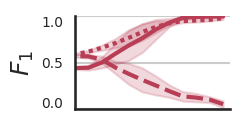

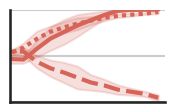

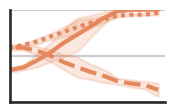

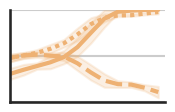

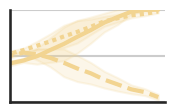

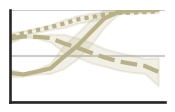

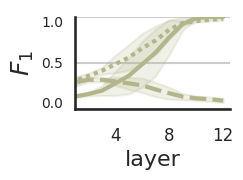

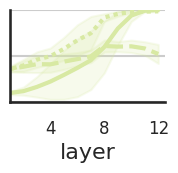

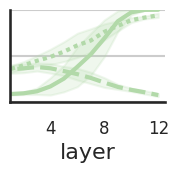

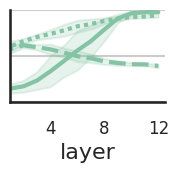

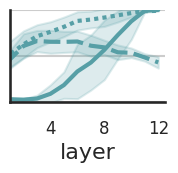

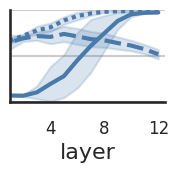

In [5]:
memorisations, initiations, d = [], [], []
all_memorisations, all_initiations, alld_probing = [], [], []
events_probing = defaultdict(lambda: defaultdict(list))

# Use slightly darker colours for SST datasets to improve visibility
utils.palette["sst5"] = "#b8bc84"
utils.palette["sst2"] = "#bfb780"

for dataset in utils.ds_names:
    mem, init = [], []
    x, y, hue = [], [], []
    for modeln, model in utils.model_setups:
        mem2, init2 = [], []
        over_seeds = []
        for seed in [1, 2, 3]:                   
            results = pickle.load(
                open(f"../results/probing/{dataset}/{model}_seed={seed}_freeze=embeddings_epoch=50.pt.pickle", 'rb'))
            memorisation, initiation = None, None
            all_f1_clean = [np.mean([results["predict_clean_label"][seed, l]["clean"]
                                     for seed in range(5)])
                                     for l in range(0, 13)]
            maxi = max(all_f1_clean)
            mini = random_performance[dataset]
            for l in range(0, 13):
                x.extend([l, l, l])
                hue.extend(["noisy", "clean", "clean2"])
                noisy_f1 = np.mean([results["predict_noisy_label"][seed, l]["noisy"]
                                    for seed in range(5)])
                clean_f1 = np.mean([results["predict_clean_label"][seed, l]["noisy"]
                                    for seed in range(5)])
                clean_f1_2 = np.mean([results["predict_clean_label"][seed, l]["clean"]
                                      for seed in range(5)])
                y.extend([noisy_f1, clean_f1, clean_f1_2])
                if noisy_f1 > clean_f1 + 0.1 and memorisation is None:
                    mem2.append(l)
                    memorisation = True
                if initiation is None and (clean_f1_2 - mini) / (maxi - mini) > 0.9:
                    init2.append(l)
                    initiation = True
        mem.append(np.mean(mem2))
        init.append(np.mean(init2))
        events_probing[modeln][dataset] = (np.mean(mem2), np.mean(init2))

    # Visualisation per dataset, showing std over models
    plt.figure(figsize=(2, 1.2))
    plt.grid(axis='y', zorder=-1)
    ax = sns.lineplot(
        x=x, y=y, zorder=1, style=hue, errorbar='sd',
        linewidth=3, color=sns.desaturate(utils.palette[dataset], 0.8))
    ax.set_xticks([4,8,12], [4,8,12], fontsize=12)
    ax.set_yticks([0, 0.5, 1], [0.0, 0.5, 1.0], fontsize=12)

    # Only use xlabel for bottom row of multi-subfigure figure
    if dataset in ["stormfront", "trec", "reuters", "sst5", "emotion", "implicithate"]:
        plt.xlabel("layer", fontsize=16)
    else:
        plt.xlabel("")
        ax.set_xticklabels([])
    # Only use ylabel for leftmost column of multi-subfigure figure
    if dataset in ["wic", "sst5"]:
        plt.ylabel(r"$F_1$")
        plt.text(-1.5, 0.02, 0.0, fontsize=10)
        plt.text(-1.5, 0.45, .5, fontsize=10)
        plt.text(-1.5, 0.89, 1.0, fontsize=10)
        ax.set_yticklabels(["", "   ", "   "])
    else:
        plt.ylabel("")
        ax.set_yticklabels([])
    plt.xlim(1, 12.5)
    plt.ylim(0, 1)
    sns.despine()
    plt.legend([], [], frameon=False)          
    plt.savefig(f"probing/cleanvsnoisy_{dataset}.pdf", bbox_inches='tight')
    plt.show()

    memorisations.append(np.mean(mem))
    initiations.append(np.mean(init))
    all_memorisations.extend(mem)
    all_initiations.extend(init)
    alld_probing.extend([dataset]*len(init))

Now summarise the "events" of memorisation >> generalisation and probes reaching near-ceiling performance in the same way as we did for the centroid analysis.

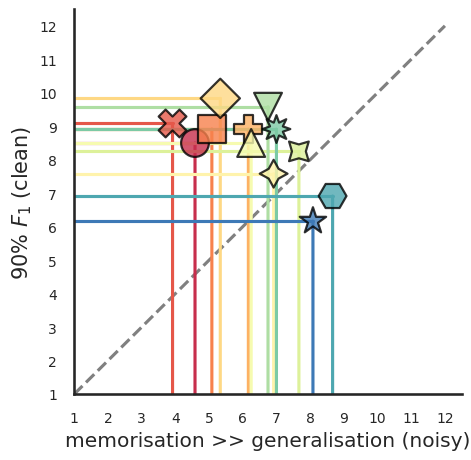

In [6]:
utils = VisualisationUtils()
utils.visualise_events(memorisations, initiations, utils.ds_names, "probing/all_events_probing.pdf", probing=True)

Now compare the centroid analysis events to the probing events using Spearman correlations.

In [7]:
events_centroids = pickle.load(open("pickled_results/centroid_events.pickle", 'rb'))
mem_probing, mem_centroids = [], []
init_probing, init_centroids = [], []
for m in events_probing:
    for d in events_probing[m]:
        mem_probing.append(events_probing[m][d][0])
        mem_centroids.append(events_centroids[m][d][0])
        init_probing.append(events_probing[m][d][1])
        init_centroids.append(events_centroids[m][d][1])

# double-check the data is in the right order
r1, p1 = scipy.stats.spearmanr(mem_probing, mem_centroids)
r2, p2 = scipy.stats.spearmanr(init_probing, init_centroids)
print(f"{r1:.2f} (p={p1:.4f}), {r2:.2f} (p={p2:.4f})")

0.84 (p=0.0000), 0.73 (p=0.0000)


In [8]:
pickle.dump(dict(events_probing), open("pickled_results/probing_events.pickle", 'wb'))